# <center> The Horsehead nebula dataset </center>

## <center> Analyzing few pixels </center>

In [1]:
# %% load modules
import os
import sys
sys.path.append(os.path.join(os.getcwd(), '.', '..'))

import numpy as np 

# TOAST toolboxs
from toolboxs.toolbox_physics.toolbox_physics import compute_moments
from toolboxs.toolbox_plot.toolbox_plot import plot_maps, show_LoS

# to show image results
from IPython.display import Image
from IPython.display import IFrame

In [ ]:
# paths
path_dataset = '***/TOAST/examples/data-horsehead/inputs'

# load the dataset
ppv = np.load(f'{path_dataset}/ppv.npy', allow_pickle=True) # position-position-velocity cubes
names_mol_line_latex = np.load(f'{path_dataset}/names_mol_line_latex.npy', allow_pickle=True) # names of molecular lines in LaTeX
names_mol = np.load(f'{path_dataset}/names_mol.npy', allow_pickle=True) # names of molecular species
names_line = np.load(f'{path_dataset}/names_line.npy', allow_pickle=True) # names of transitions per species
velocity_channels = np.load(f'{path_dataset}/velocity_channels.npy', allow_pickle=True) # velocity axis (km/s)
velocity_res = np.load(f'{path_dataset}/velocity_res.npy', allow_pickle=True) # velocity resolution (km/s)

## <center> Integrated intensity maps [K.km/s] </center>

Take a look at the Horsehead nebula through the integrated intensity maps of the molecular lines 
- $^{12}\text{CO}(1-0)$, 
- $^{13}\text{CO}(1-0), (2-1)$, 
- $\text{C}^{18}\text{O}(1-0), (2-1)$ 
- $\text{HCO}^{+}(1-0)$, 
- $\text{H}^{13}\text{CO}^{+}(1-0)$.

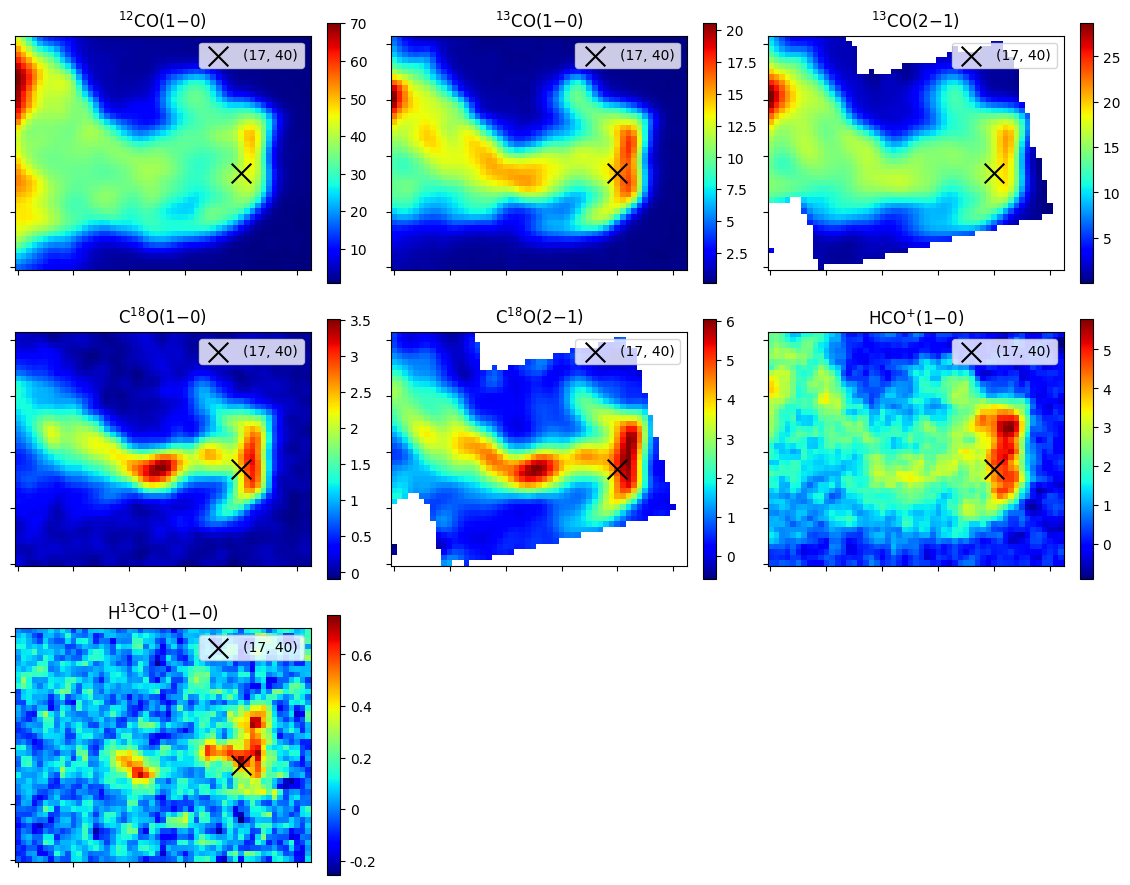

In [3]:
# compute zero-order moments (K.km/s)
moment_0 = []
ravel_names_mol_line_latex = []
for mol_idx in range(len(names_mol)) : 
    for line_idx in range(len(names_line[mol_idx])) : 
        cube = ppv[mol_idx][line_idx]
        velocity_channels_ = velocity_channels[mol_idx][line_idx]
        velocity_res_ = velocity_res[mol_idx][line_idx]
        moment_0.append(compute_moments(0, 
                                cube, 
                                velocity_channels_, 
                                velocity_res_, 
                                C_V = 10.5 * np.ones((cube.shape[0], cube.shape[1])))[0])
        ravel_names_mol_line_latex.append(names_mol_line_latex[mol_idx][line_idx])

# coordinates of one sight-line to study
pixel = [17, 40] # (row index, column index) /!\ it starts from 0 in Python

# show maps 
name_fig = 'maps_w_0'
fig = plot_maps(
    maps = moment_0,
    titles = ravel_names_mol_line_latex, 
    pixel = pixel
)

## <center> Focusing on one sight-line <center> 

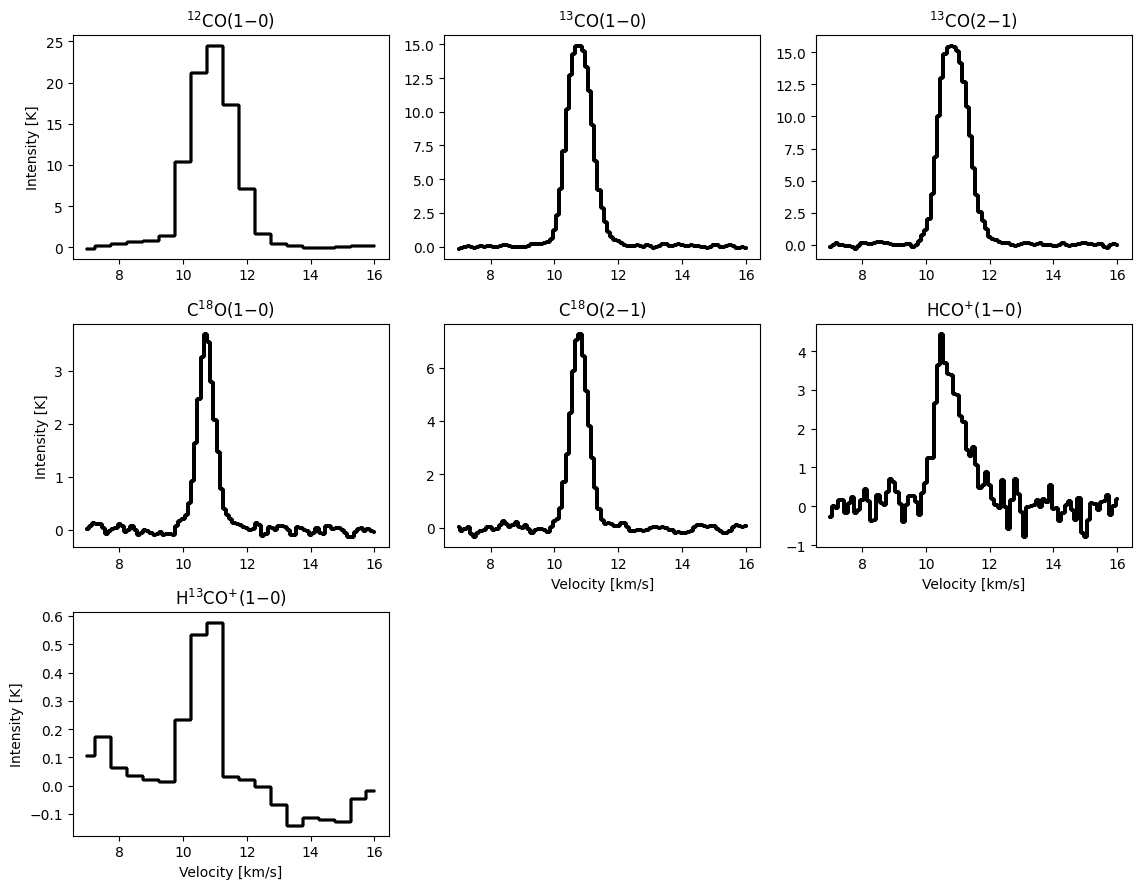

In [4]:
pixel = [17, 40] # (row index, column index) /!\ it starts from 0 in Python

# measures
LoS_ppv = []
LoS_velocity_channels = []
ravel_names_mol_line_latex = []
for mol_idx in range(len(names_mol)) : 
    for line_idx in range(len(names_line[mol_idx])) : 
        spectrum = ppv[mol_idx][line_idx][pixel[0], pixel[1], :]
        LoS_ppv.append(spectrum)
        velocity_channels_ = velocity_channels[mol_idx][line_idx][0, :]
        LoS_velocity_channels.append(velocity_channels_)
        ravel_names_mol_line_latex.append(names_mol_line_latex[mol_idx][line_idx])

# plot
fig = show_LoS(
    LoS_ppv,
    LoS_velocity_channels,
    ravel_names_mol_line_latex,
    name_fig=f'pixel_{pixel[0]}_{pixel[1]}',
)

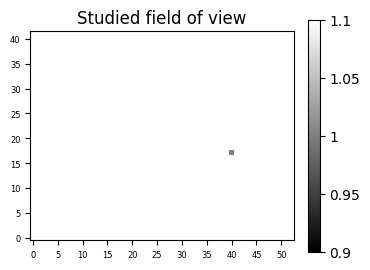

In [5]:
# Once you chose your pixel, create a map of the field of view (FoV)
FoV = np.zeros((ppv[0][0].shape[0], ppv[0][0].shape[1]))
FoV.fill(np.nan)
FoV[pixel[0], pixel[1]] = 1 # here, the studied field of view contains only one sight-line 

# save it in the folder data-horsehead/inputs/ 
np.save(f'{path_dataset}/FoV', FoV)

# check on the FoV map 
name_fig = 'FoV'
fig = plot_maps(
    maps=[FoV],
    titles=[r'Studied field of view'],
    array_coordinates=True, 
    cmap = ['gray']
    )

## <center> Model fitting <center> 

We aim characterizing the gas state in this pixel, i.e., estimating its properties ($T_{kin}$, $n_{H_2}$, etc.) by fitting a model to these molecular lines. 
Whatever the model of cloud you choose, `TOAST` performs the optimization of the model fitting with a two-step approach by: $\\$
1) Searching the solution in a physical space (pre-computed `RADEX` grids), 
2) Refining this solution with a gradient descent (`RADEX` is run on the fly).

To initialize the step 1), it requires to provide an initial guess for the systemic centroid velocity (C_V) of the cloud.  
We provide this map in the folder `data-horsehead/inputs/maps_C_V.map` (see details about its computation in reference [1]). 
When using `TOAST` to your own dataset, please do not forget to provide this map.


## Customize the model  

The general using of `TOAST` is 
1) Customize the cloud model by modify the file `model.py` as writing in a `.text` file. 
This file is composed of several sections, e.g., the cloud model, verbose and numerical setting.
2) Then, to launch the model fitting procedure, run the shell command $\\$
    ```console
    $ python launch_model_fitting.py
    ```
    Once the code is finished, the results are saved in the folder `outputs/`. Estimation results are saved in `outputs/estimations/` as `numpy` arrays (and optionally written in `.txt` file).



### From homogeneous cloud to multilayer model 

To begin with, let's try fitting a simple model, made of a single and homogeneous layer of gas. 

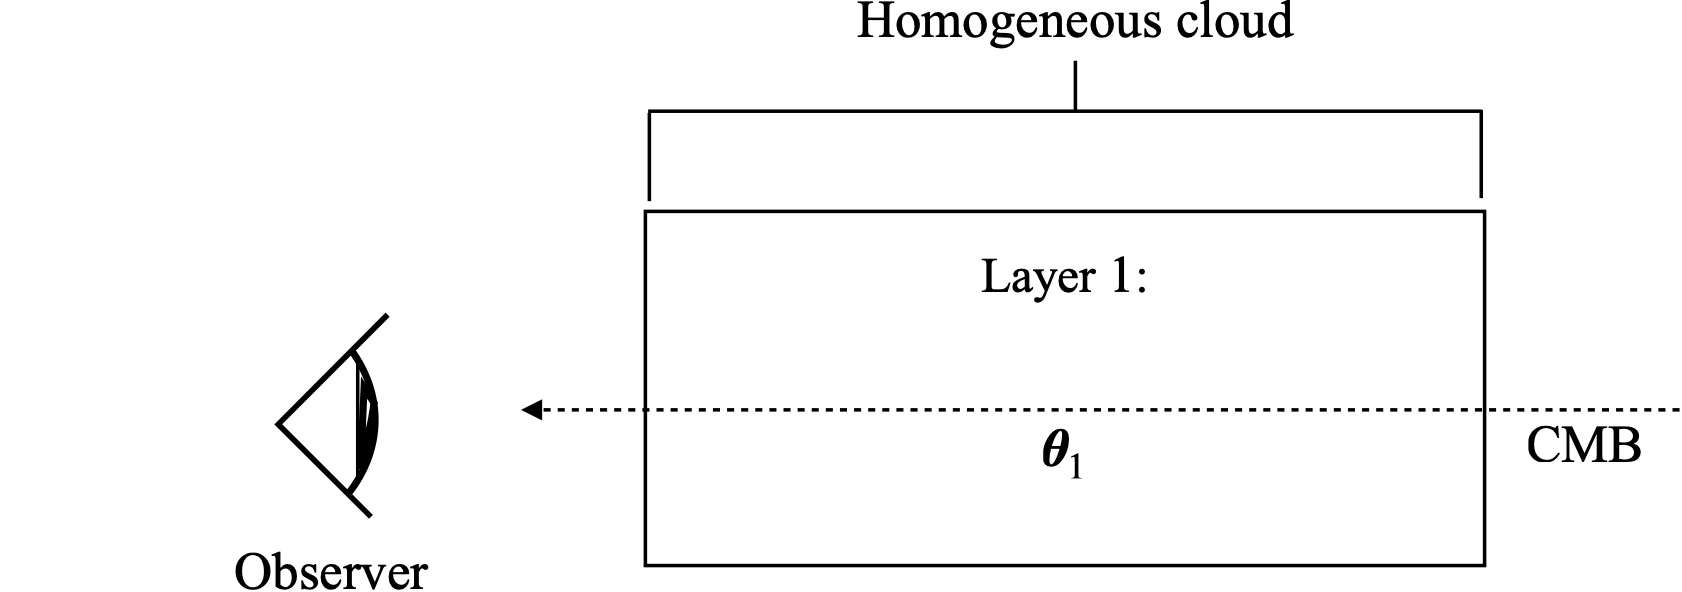

In [6]:
# sketch of the model 
# theta is the vector of parameters characterizing the gas (Tkin, nH2, colden, FWMH, C_V)
img = Image(f'schema/homogeneous-cloud.png', width=600)
img

A filled template `model_analyze_one_pixel.py` is provided in the folder `TOAST/`. <font color='red'> First, rename it `model.py`</font> (in `model.py`, modify the section `paths` as well). Then, launch the model fitting procedure by typing in your terminal: <code> python launch_model_fitting.py </code> or executing the cell below.

In [8]:
# launch the model fitting 

os.system('python .././launch_model_fitting.py')


 Starting horsehead's analysis (1 pixels)
	Analyzing the pixel (i, j) = (17, 40)


  0%|          | 0/1 [00:00<?, ?it/s]

	[is running] Grid search


100%|██████████| 2010/2010 [00:04<00:00, 429.96it/s] 



 horsehead's analysis done.


100%|██████████| 1/1 [00:05<00:00,  5.72s/it]


0

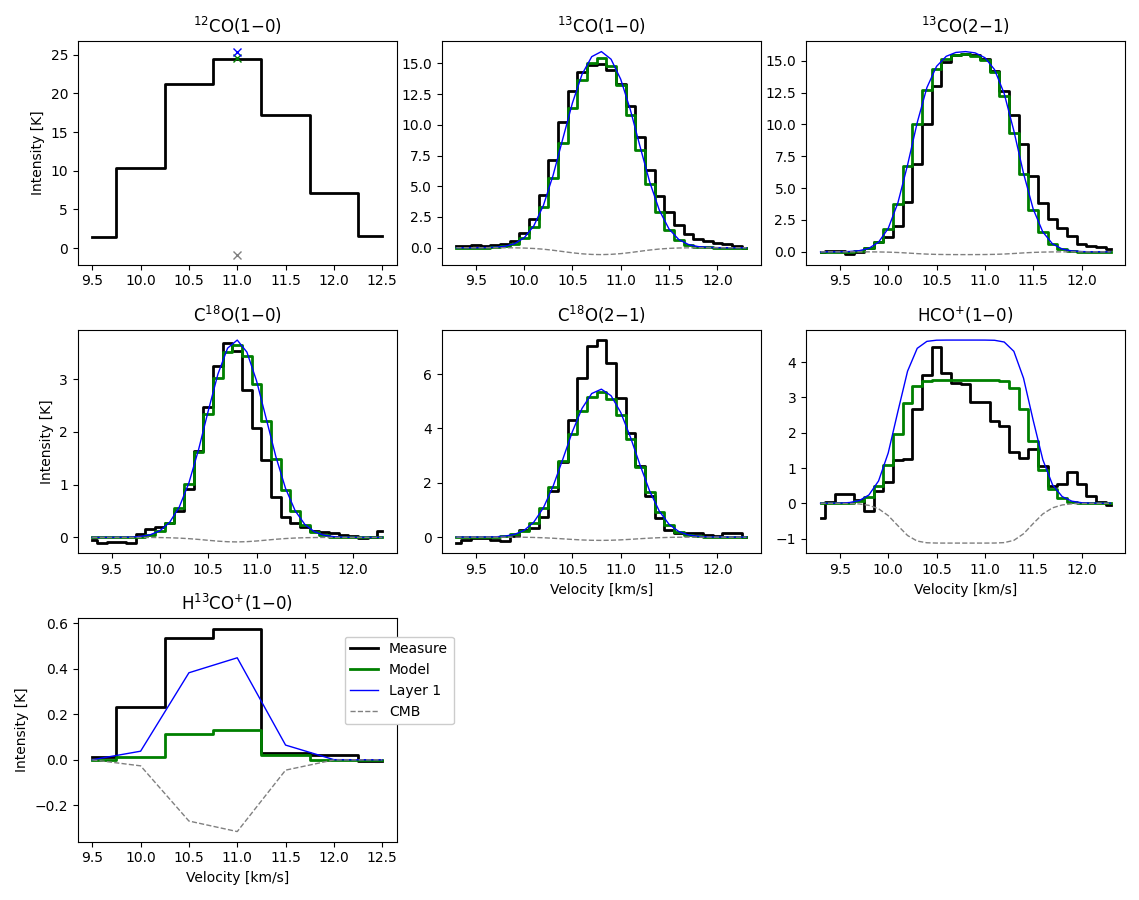

In [9]:
# checking the model fitting

img = Image(f'analyze_one_pixel/outputs/figures/model-fit-{pixel[0]}-{pixel[1]}-0.png', width=600)
img 
# Measures: black, Model: green
# Contribution of the different layer: color  
# CMB: dashed grey 

In [10]:
# checking the estimation results, from the random walk (the search in the gridded space), 
# written in readable files `result_rw`

# NLL is the Negative Log-Likelihood, the criterion that we are minimizing
# Walkers are the vectors of parameters spread in the space. 
# The number of walkers found at the minimum NLL can be used as an insight of the convergence.

file = open(f'analyze_one_pixel/outputs/results_rw', 'r')
textfile = file.read()
print(textfile)

------+-----------------+-----------------------+----------+------
------+-----------------+-----------------------+----------+------
Test 0 : (i, j) = (17, 40)
------+-----------------+-----------------------+----------+------
 Step | Iter./Max Iter. | Walkers min(NLL)/tot. | Min(NLL) | Time 
------+-----------------+-----------------------+----------+------
 1    | 10/10           | 1/10000               | 240.82   | 0.6489 
 2    | 1000/1000       | 548/1000              | 230.73   | 3.4211 
 3    | 1000/1000       | 1/4                   | 230.73   | 0.6055 
 All  |                 |                       |          | 4.68 
--------------------+--------------------
 param / Layer      |                  1 
--------------------+--------------------
 log(Tkin / K)      | log(28.318) (25 %) 
 Tex [K], tau
 12co (1-0)         |       28.08, 49.75 
 13co (1-0)         |        27.88, 1.00 
      (2-1)         |        20.93, 3.80 
 c18o (1-0)         |        41.79, 0.10 
      (2-1)   

This homogeneous model fails to fit both the {diffuse, warm} gas tracers (e.g., $\text{CO}$, $^{13}\text{CO}$ lines) and {dense, cold} ones (e.g., $\text{C}^{18}\text{O}$ lines and $\text{H}^{13}\text{CO}^{+}(1-0)$). Let's fit a two-layer model, then. 

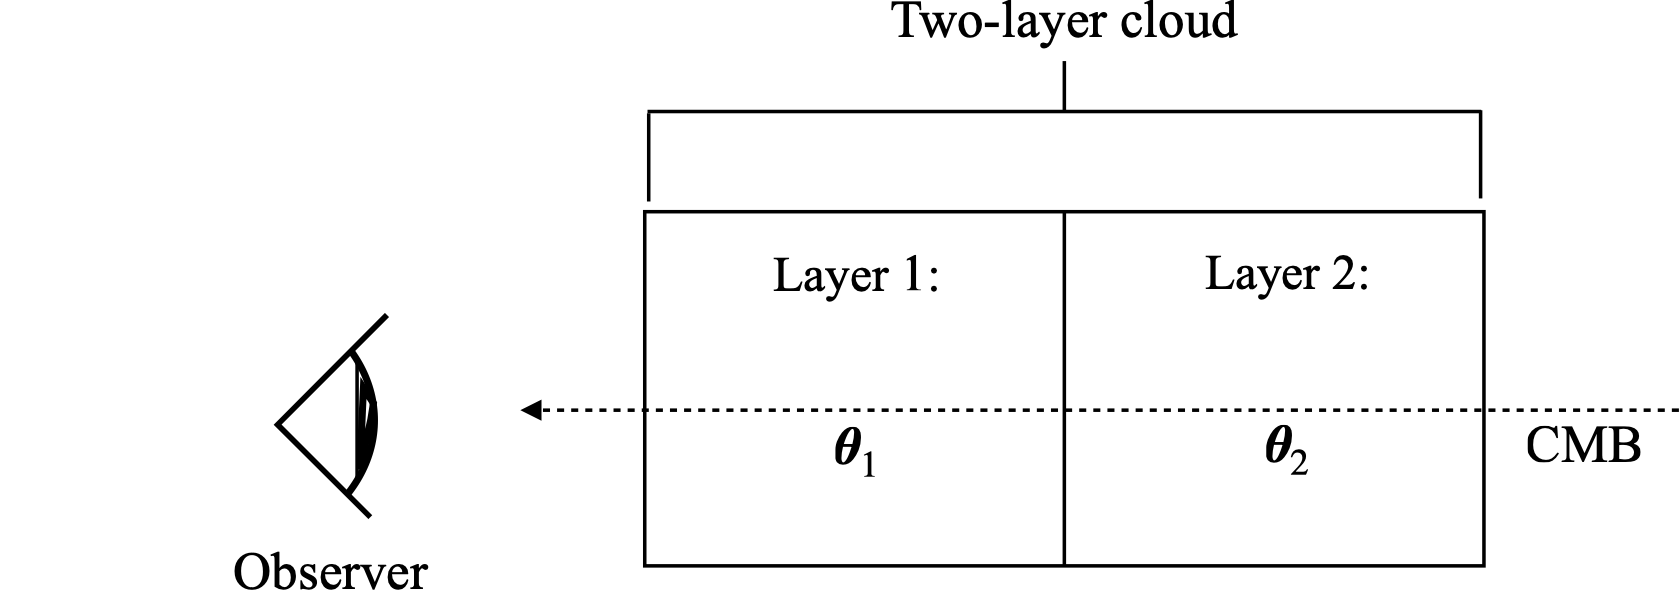

In [11]:
# sketch of the model 
# theta is the vector of parameters characterizing the gas (Tkin, nH2, colden, FWMH, C_V)

img = Image(f'schema/two-layer-cloud.png', width=600)
img

To do so, put `layers = 2` in `model.py`, section `layers and geometry`. Since there are twice more parameters to estimate, you can increase the number of walkers and/or iterations used during the random walk by adjusting the parameters `walkers_per_step` and `iteration_per_step`, in section `model fitting settings` (see details about these parameters in reference [1]).

<code> # for rw optimization </code> $\\$
<code> walkers_per_step = [10000, 1000, 100] </code> $\\$
<code> iterations_per_step = [10, 1000, 2000] </code> $\\$

In [12]:
# launch the model fitting 

os.system('python .././launch_model_fitting.py')


 Starting horsehead's analysis (1 pixels)
	Analyzing the pixel (i, j) = (17, 40)


  0%|          | 0/1 [00:00<?, ?it/s]

	[is running] Grid search


100%|██████████| 3010/3010 [00:12<00:00, 250.44it/s]



 horsehead's analysis done.


100%|██████████| 1/1 [00:12<00:00, 12.97s/it]


0

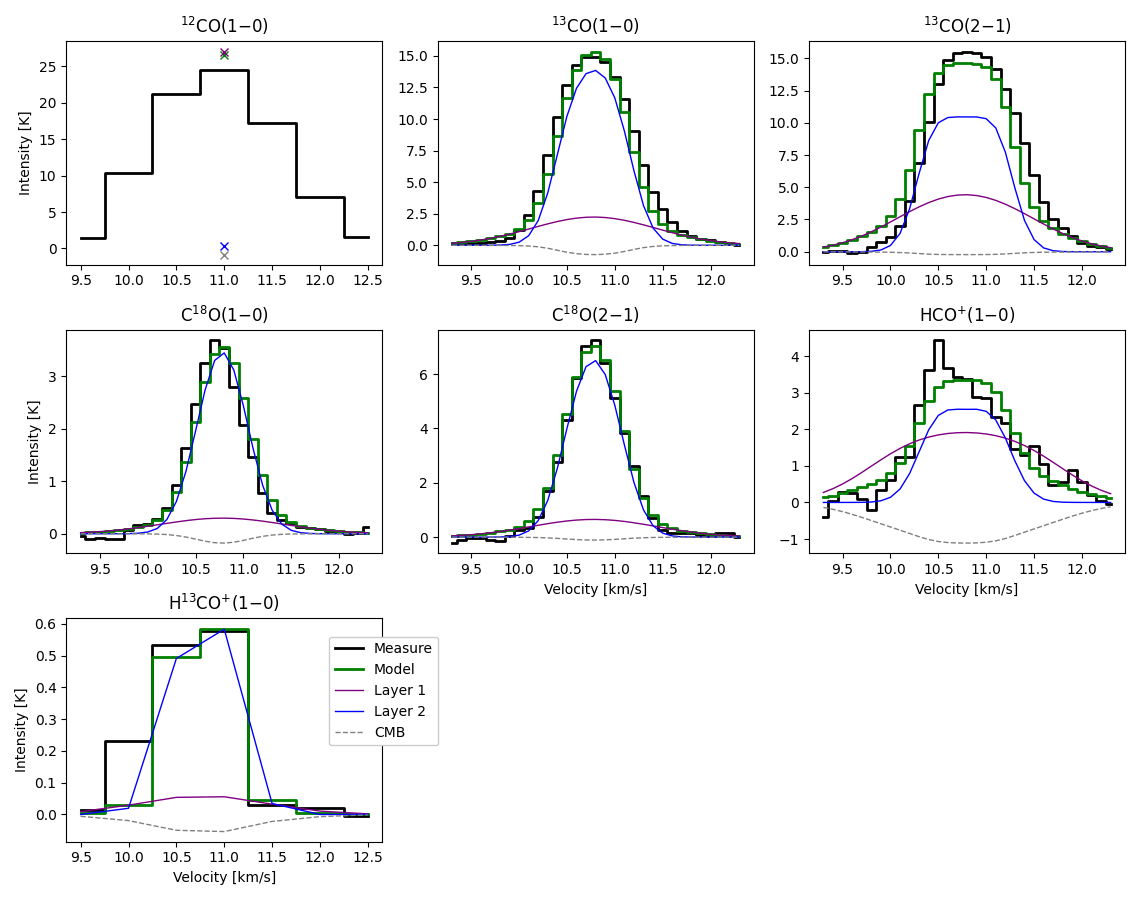

In [13]:
# checking the model fitting

img = Image(f'analyze_one_pixel/outputs/figures/model-fit-{pixel[0]}-{pixel[1]}-0.png', width=600)
img
# Measures: black, Model: green
# Contribution of the different layer: color  
# CMB: dashed grey 

### Kinematics

So far, the centroid velocities of all layers are constrained to be the same. To reproduce asymmetrical profiles, e.g., the $\text{HCO}^{+}$ line, let's remove this constraint. To do so, in `model.py`, section `kinematics`, put `constraints_kinematics = []` instead of `constraints_kinematics = ['same_C_V_in_all_layers']`.

In [14]:
# launch the model fitting 

os.system('python .././launch_model_fitting.py')


 Starting horsehead's analysis (1 pixels)
	Analyzing the pixel (i, j) = (17, 40)


  0%|          | 0/1 [00:00<?, ?it/s]

	[is running] Grid search


100%|██████████| 3010/3010 [00:11<00:00, 252.55it/s]



 horsehead's analysis done.


100%|██████████| 1/1 [00:12<00:00, 12.86s/it]


0

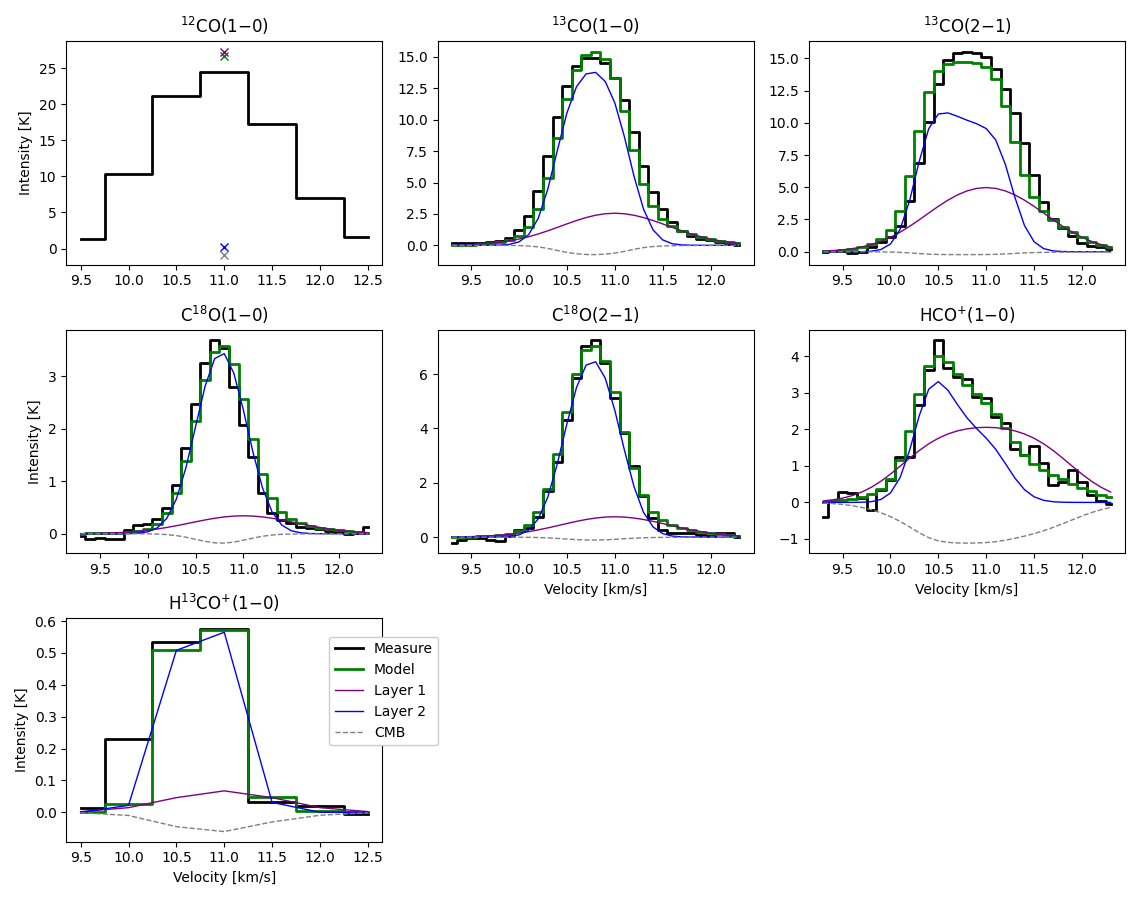

In [15]:
# checking the model fitting
 
img = Image(f'analyze_one_pixel/outputs/figures/model-fit-{pixel[0]}-{pixel[1]}-0.png', width=600)
img 
# Measures: black, Model: green
# Contribution of the different layer: color  
# CMB: dashed grey 

### Optimization

Once the model is suited to your needs, refine the solution with a gradient descent, by setting in `model.py`, section `model fitting settings`, `optimization = 'gd'`. 


**Note**: `rw-gd` allows one to run successively the random walk and the gradient descent, but since the latter requires launching `RADEX` on the fly, this step can be time-consuming. 
We thus suggest processing the gradient descent only once you are confident enough in your model.

In [17]:
# launch the model fitting (gradient descent) 

os.system('python .././launch_model_fitting.py')


 Starting horsehead's analysis (1 pixels)
	Analyzing the pixel (i, j) = (17, 40)


  0%|          | 0/1 [00:00<?, ?it/s]

	[is running] Gradient descent Done.
 horsehead's analysis done.


100%|██████████| 1/1 [01:09<00:00, 69.97s/it]


0

In [18]:
# checking the final estimation results, from the gradient descent
# written in readable files `result_gd`

# NLL is the Negative Log-Likelihood, the criterion that we are minimizing
# Iter. is the number of iterations that have been done to reach the convergence 

file = open(f'analyze_one_pixel/outputs/results_gd', 'r')
textfile = file.read()
print(textfile)

----------+-----------------+------
----------+-----------------+------
Test 0 : (i, j) = (17, 40)
----------+-----------------+------
 Min(NLL) | Iter./Max Iter. | Time 
----------+-----------------+------
 119.4625 | 8/30            | 68.93 
--------------------+--------------------+--------------------
 param / Layer      | 1                  |                  2 
--------------------+--------------------+--------------------
 log(Tkin / K)      | log(30.278)        |        log(20.239) 
 Tex [K], tau
 12co (1-0)         | 29.22, 5.33        |      20.24, 116.98 
 13co (1-0)         | 47.81, 0.07        |        20.24, 1.72 
      (2-1)         | 19.94, 0.46        |        20.18, 4.69 
 c18o (1-0)         | 57.38, 0.01        |        20.35, 0.22 
      (2-1)         | 18.74, 0.06        |        20.11, 0.60 
 hcop (1-0)         | 4.34, 2.25         |        20.17, 2.37 
 h13cop (1-0)       | 3.58, 0.04         |        38.79, 0.03 
 log(nH2 /cm-3)     | 3.956              |       

### Relative abundances

For all the models previously studied, the relative abundances are assumed to be fixed (the one chosen when the grids of $T_{ex}$ and $\tau$ have been computed). You might want to refine their values by estimating some of them. To illustrate it, let's move in a translucent region of the cloud.  

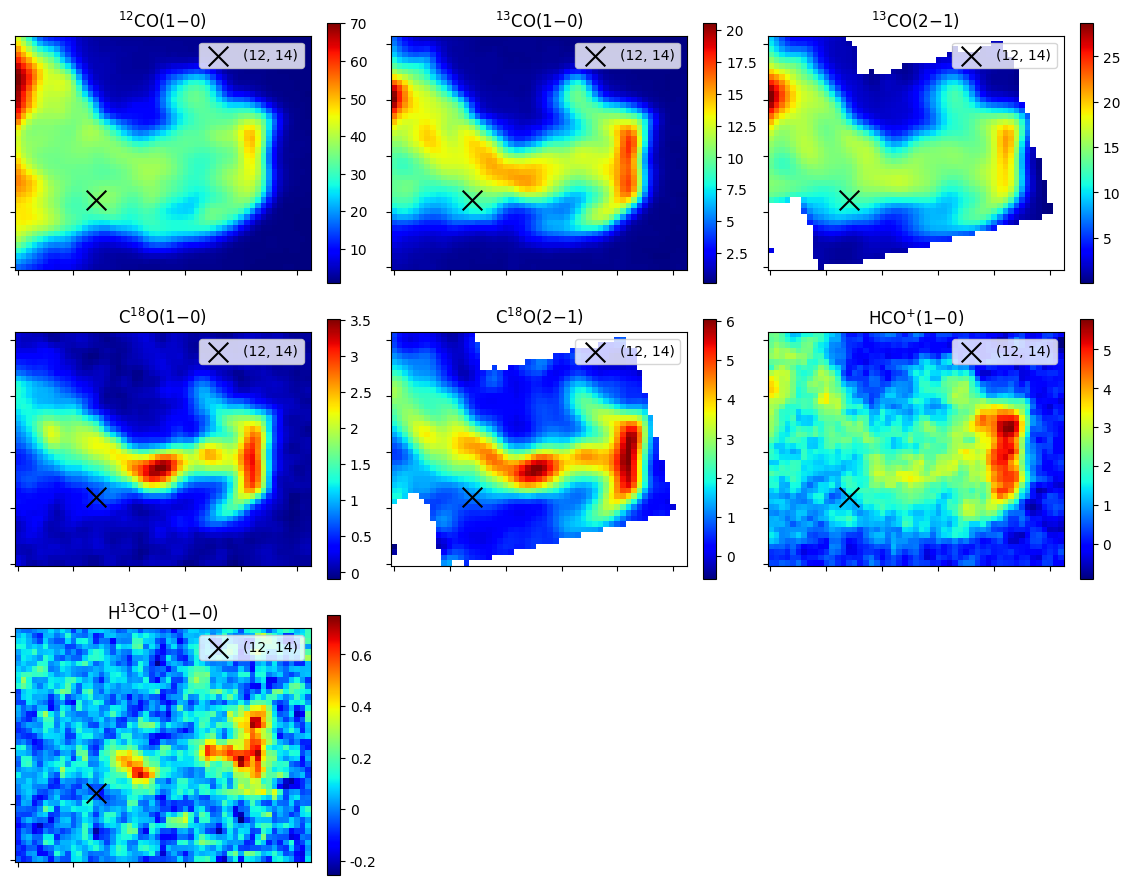

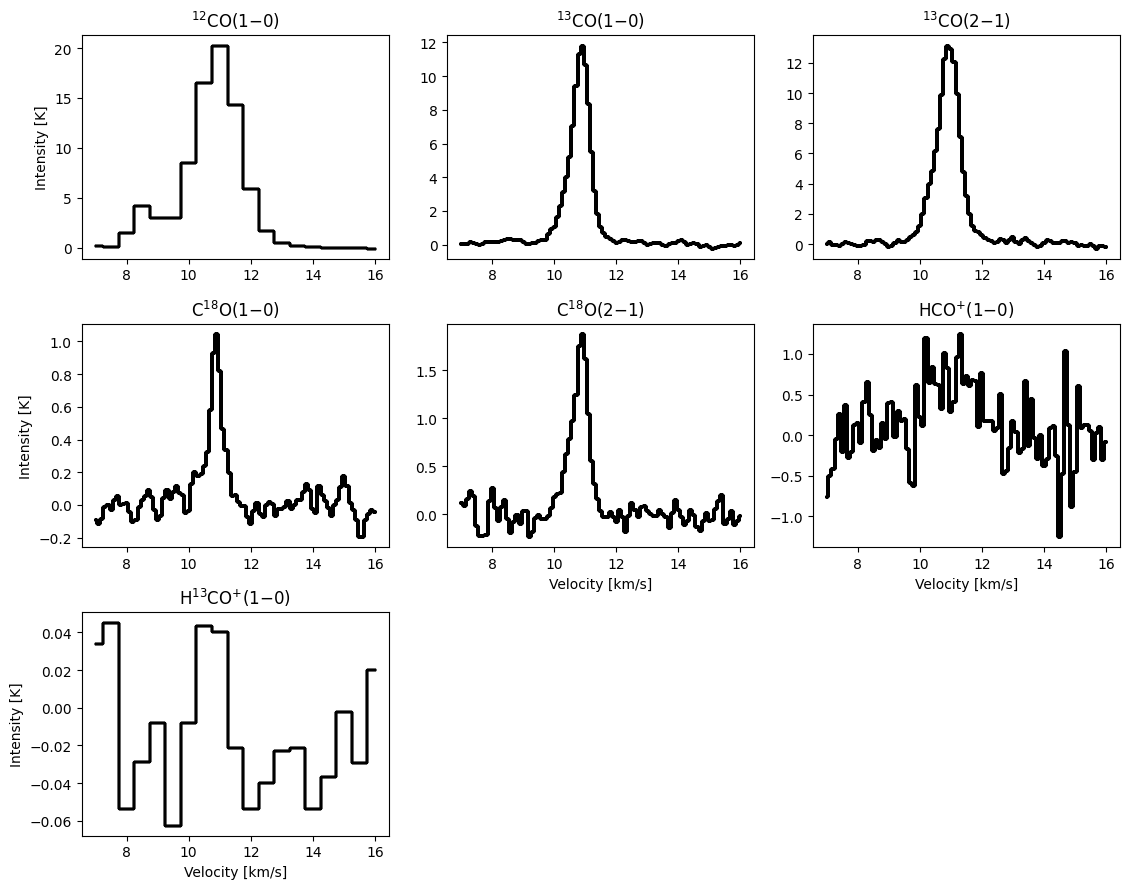

In [19]:
# coordinates of one sight-line to study
pixel = [12, 14] # (row index, column index) /!\ it starts from 0 in Python

# show maps 
name_fig = 'maps_w_0'
fig = plot_maps(
    maps = moment_0,
    titles = ravel_names_mol_line_latex, 
    pixel = pixel
)

# measures
LoS_ppv = []
LoS_velocity_channels = []
ravel_names_mol_line_latex = []
for mol_idx in range(len(names_mol)) : 
    for line_idx in range(len(names_line[mol_idx])) : 
        spectrum = ppv[mol_idx][line_idx][pixel[0], pixel[1], :]
        LoS_ppv.append(spectrum)
        velocity_channels_ = velocity_channels[mol_idx][line_idx][0, :]
        LoS_velocity_channels.append(velocity_channels_)
        ravel_names_mol_line_latex.append(names_mol_line_latex[mol_idx][line_idx])

# plot
fig_2 = show_LoS(
    LoS_ppv,
    LoS_velocity_channels,
    ravel_names_mol_line_latex,
    name_fig=f'pixel_{pixel[0]}_{pixel[1]}',
)

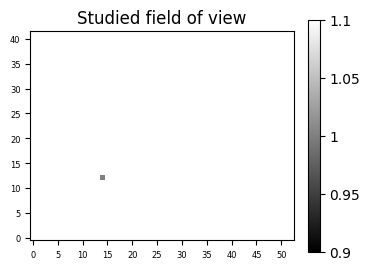

In [20]:
# Once you chose your pixel, create a map of the field of view (FoV) to study
FoV = np.zeros((ppv[0][0].shape[0], ppv[0][0].shape[1]))
FoV.fill(np.nan)
FoV[pixel[0], pixel[1]] = 1 # here, the studied field of view contains only one sight-line 

# save it in the folder data-horsehead/inputs/ 
np.save(f'{path_dataset}/FoV', FoV)

# check on the FoV map 
name_fig = 'FoV'
fig = plot_maps(
    maps=[FoV],
    titles=[r'Studied field of view'],
    array_coordinates=True, 
    cmap = ['gray']
    )

In `model.py`, section `model fitting settings`, <font color='red'> set again `optimization = 'rw'`</font>. 

In [21]:
# launch the model fitting 

os.system('python .././launch_model_fitting.py')


 Starting horsehead's analysis (1 pixels)
	Analyzing the pixel (i, j) = (12, 14)


  0%|          | 0/1 [00:00<?, ?it/s]

	[is running] Grid search


100%|██████████| 3010/3010 [00:11<00:00, 251.64it/s]



 horsehead's analysis done.


100%|██████████| 1/1 [00:13<00:00, 13.02s/it]


0

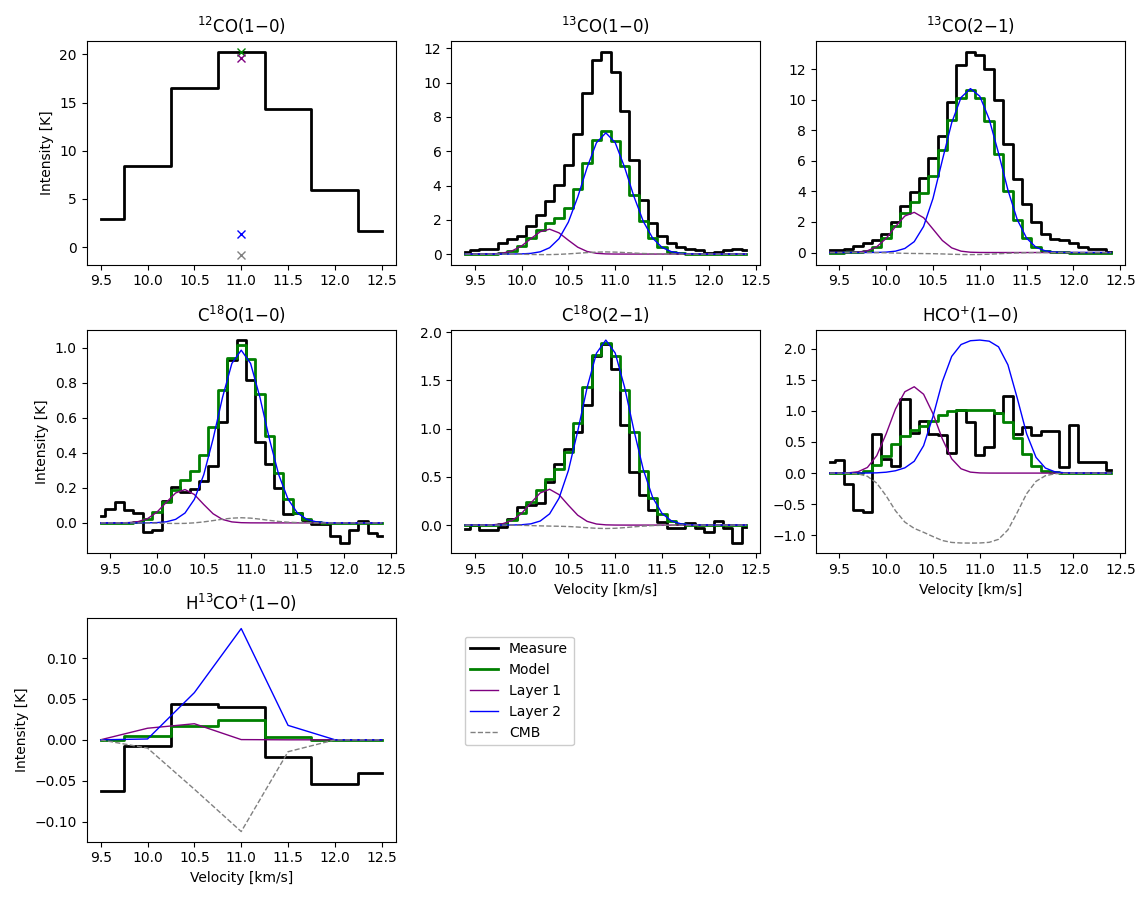

In [22]:
# checking the model fitting

img = Image(f'analyze_one_pixel/outputs/figures/model-fit-{pixel[0]}-{pixel[1]}-0.png', width=600)
img 
# Measures: black, Model: green
# Contribution of the different layer: color  
# CMB: dashed grey 

The $^{13}\text{CO}$ lines are under-fitted, while the $\text{C}^{18}\text{O}$ lines are over-fitted. This systemic trend is noticed in [1], for the sight-lines with low visual extinction ($A_v \lesssim 10 \text{ mag}$), which suggests that the injected prior on N($^{13}\text{CO}$)/N($\text{C}^{18}\text{O}$) is biased. To estimate this column density ratio (or abundance ratio), in `model.py`, section `chemistry`, put `model_chemistry = '13co-c18o'` instead of `'basic'`. 

In [23]:
# launch the model fitting 

os.system('python .././launch_model_fitting.py')


 Starting horsehead's analysis (1 pixels)
	Analyzing the pixel (i, j) = (12, 14)


  0%|          | 0/1 [00:00<?, ?it/s]

	[is running] Grid search


100%|██████████| 3010/3010 [00:11<00:00, 258.75it/s]



 horsehead's analysis done.


100%|██████████| 1/1 [00:12<00:00, 12.59s/it]


0

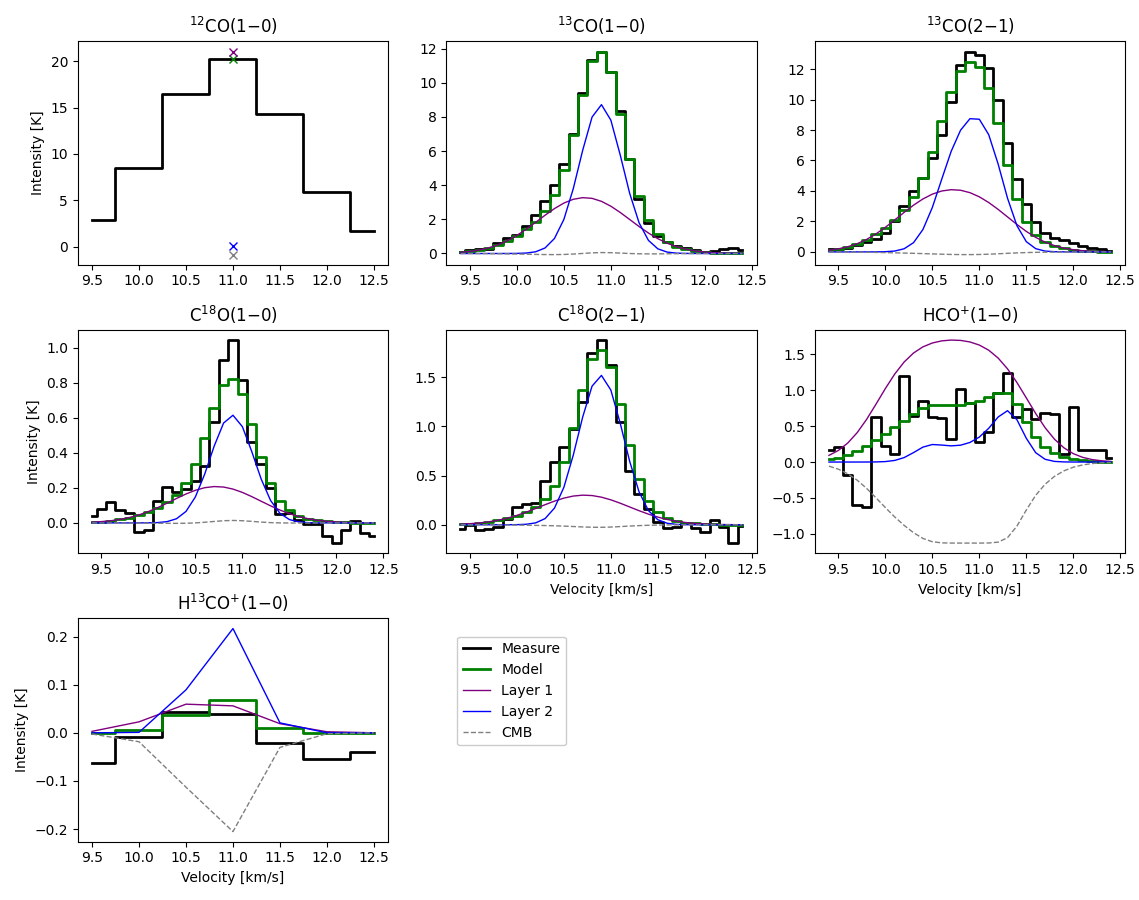

In [24]:
# checking the model fitting

img = Image(f'analyze_one_pixel/outputs/figures/model-fit-{pixel[0]}-{pixel[1]}-0.png', width=600)
img 
# Measures: black, Model: green
# Contribution of the different layer: color  
# CMB: dashed grey 

In [25]:
# checking the estimation results, from the random walk (the search in the gridded space), 
# written in readable files `result_rw`

# NLL is the Negative Log-Likelihood, the criterion that we are minimizing
# Walkers are the vectors of parameters spread in the space. 
# The number of walkers found at the minimum NLL can be used as an insight of the convergence.

file = open(f'analyze_one_pixel/outputs/results_rw', 'r')
textfile = file.read()
print(textfile)

------+-----------------+-----------------------+----------+------
------+-----------------+-----------------------+----------+------
Test 0 : (i, j) = (12, 14)
------+-----------------+-----------------------+----------+------
 Step | Iter./Max Iter. | Walkers min(NLL)/tot. | Min(NLL) | Time 
------+-----------------+-----------------------+----------+------
 1    | 10/10           | 1/10000               | 86.19    | 0.8610 
 2    | 1000/1000       | 1/1000                | 28.23    | 6.2506 
 3    | 2000/2000       | 4/100                 | 27.87    | 4.5219 
 All  |                 |                       |          | 11.64 
--------------------+--------------------+--------------------
 param / Layer      | 1                  |                  2 
--------------------+--------------------+--------------------
 log(Tkin / K)      | log(25.238) (66 %) | log(112.735) (13 %) 
 Tex [K], tau
 12co (1-0)         | 23.71, 7.30        |        98.84, 2.67 
 13co (1-0)         | 31.68, 0.12

The `'13co-c18o'` model is studied in more detail in [1]. When studying your own dataset, customize your chemical model by defining the abundance ratios, and in which layer, should be estimated/fixed.